In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

TRAIN_DIR = "Final_Dataset/train"
TEST_DIR  = "Final_Dataset/test"

class_names = ['Valo_Chele_Meheraj', 'Vondo_Oni', 'Amit']
NUM_CLASSES = len(class_names)

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1782 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


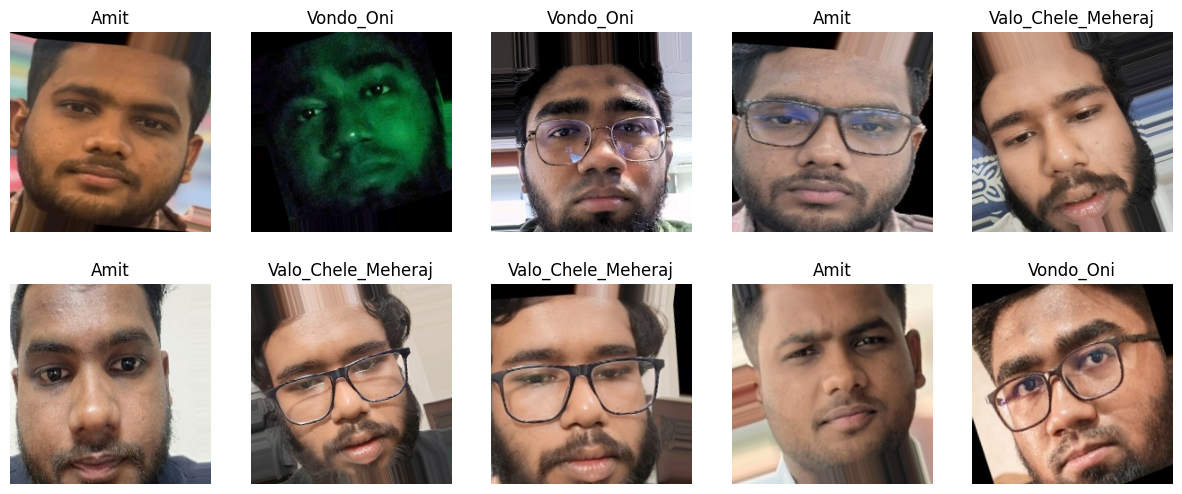

In [4]:
images, labels = next(train_generator)

plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    img = images[i]
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()


In [5]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3),
    alpha=0.75   # lighter than default
)

base_model.trainable = False


5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
base_model.summary()

Model: "mobilenetv2_0.75_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        648 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,382,064 (5.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,382,064 (5.27 MB)

In [7]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.75_224            │ (None, 7, 7, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,546,419 (5.90 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8659 - loss: 0.3445 - val_accuracy: 0.9420 - val_loss: 0.1053
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9703 - loss: 0.0886 - val_accuracy: 0.9420 - val_loss: 0.1206
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9815 - loss: 0.0586 - val_accuracy: 0.9710 - val_loss: 0.0921
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9899 - loss: 0.0420 - val_accuracy: 0.9855 - val_loss: 0.0410
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9882 - loss: 0.0448 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9899 - loss: 0.0322 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9910 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0195
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9899 - loss: 0.0312 - val_accuracy: 1.0000 - val_lo

In [11]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
fine_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9630 - loss: 0.1195 - val_accuracy: 0.9565 - val_loss: 0.0865
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9949 - loss: 0.0131 - val_accuracy: 0.9565 - val_loss: 0.0916
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9978 - loss: 0.0071 - val_accuracy: 0.9275 - val_loss: 0.2117
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9966 - loss: 0.0119 - val_accuracy: 0.9420 - val_loss: 0.1429
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0134
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9983 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9989 - loss: 0.0023 - val_accuracy: 1.0000 - v

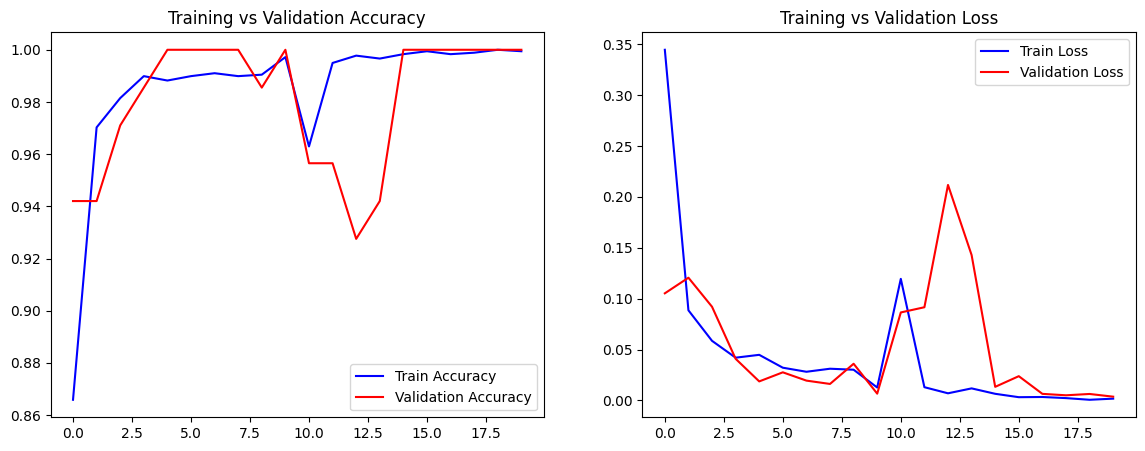

In [14]:
acc = history.history['accuracy'] + fine_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_history.history['val_accuracy']

loss = history.history['loss'] + fine_history.history['loss']
val_loss = history.history['val_loss'] + fine_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, 'b', label='Train Accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss curve
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, 'b', label='Train Loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

In [15]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 1.0000 - loss: 0.0037
Test Accuracy: 100.00%


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


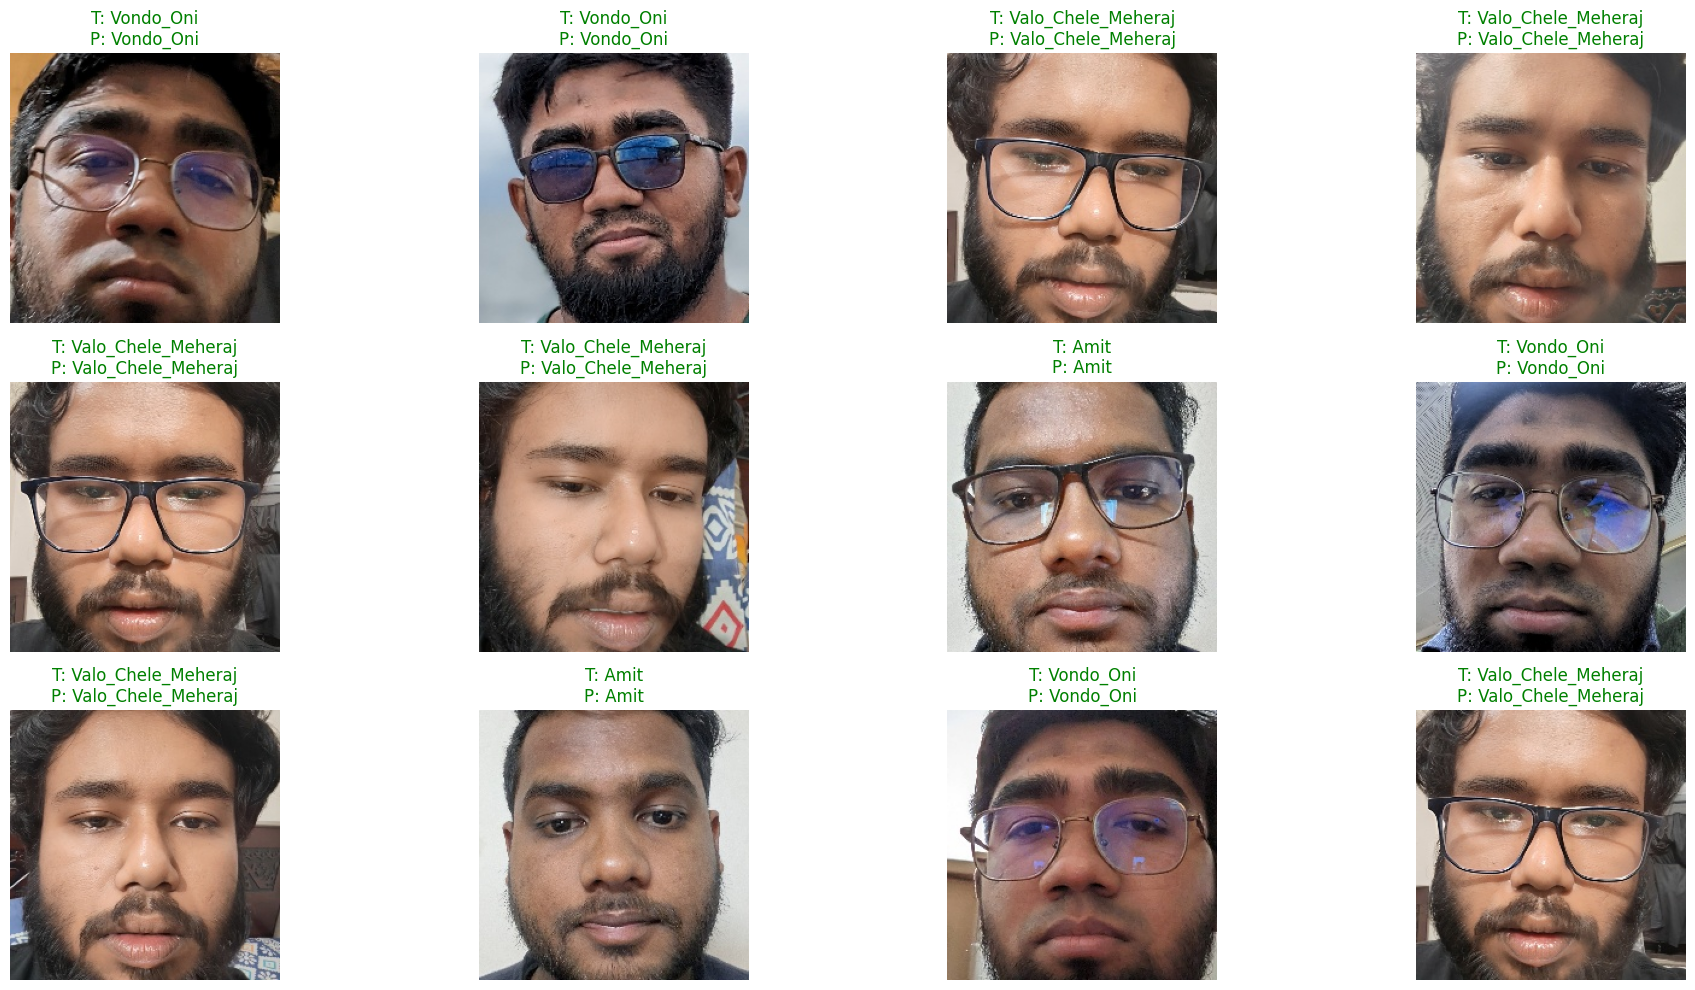

In [19]:
import random

y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes
paths = test_generator.filepaths

# random indices from entire test set
idxs = random.sample(range(len(paths)), 12)

plt.figure(figsize=(20,10))
for j, i in enumerate(idxs):
    plt.subplot(3,4,j+1)
    img = plt.imread(paths[i])
    plt.imshow(img)

    color = 'green' if y_pred[i] == y_true[i] else 'red'
    plt.title(
        f"T: {class_names[y_true[i]]}\nP: {class_names[y_pred[i]]}",
        color=color
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
model.save("face_classifier_mobilenetv2.keras")

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("MobileNetV2 model & class names saved")

MobileNetV2 model & class names saved
